训练数据集的数据个数 = 39209
图像尺寸  = (32, 32, 3)
类别数量 = 43
Number of training examples = 39209
Image data shape  = (32, 32, 3)
Number of classes = 43
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   640         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 16, 16, 64)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 16, 16, 64) 

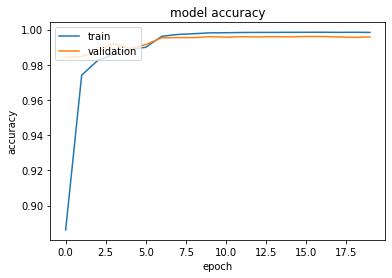

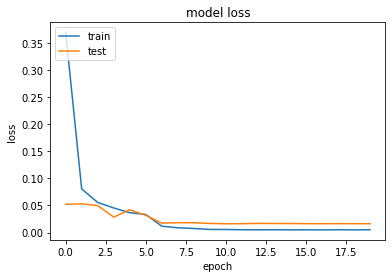

12630/12630 [==============================] - 1s 100us/step
acc: 0.9604908947140474


In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import utils
from keras.models import load_model
from keras.layers.merge import concatenate
from keras import callbacks
np.random.seed(23)

def load_traffic_sign_data(training_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)

    X_train, y_train = train['features'], train['labels']

    return X_train, y_train


def show_random_samples(X_train, y_train, n_classes):
    # show a random sample from each class of the traffic sign dataset
    rows, cols = 4, 12
    fig, ax_array = plt.subplots(rows, cols)
    plt.suptitle('Random Samples (one per class)')
    for class_idx, ax in enumerate(ax_array.ravel()):
        if class_idx < n_classes:
            # show a random image of the current class
            cur_X = X_train[y_train == class_idx]
            cur_img = cur_X[np.random.randint(len(cur_X))]
            ax.imshow(cur_img)
            ax.set_title('{:02d}'.format(class_idx))
        else:
            ax.axis('off')
    # hide both x and y ticks
    plt.figure(figsize=(8, 8))
    plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
    plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
    plt.draw()


def show_classes_distribution(n_classes, y_train, n_train):
    # bar-chart of classes distribution
    train_distribution = np.zeros(n_classes)
    for c in range(n_classes):
        train_distribution[c] = np.sum(y_train == c) / n_train
    fig, ax = plt.subplots()
    col_width = 1
    bar_train = ax.bar(np.arange(n_classes), train_distribution, width=col_width, color='r')
    plt.figure(figsize=(8, 8))
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Class Label')
    ax.set_title('Distribution')
    ax.set_xticks(np.arange(0, n_classes, 5) + col_width)
    ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
    plt.show()

def preprocess_features(X):
    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])#只考虑亮度
    X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)),2) for img in X])
    X = np.float32(X)
    X -= np.mean(X,axis=0)
    X /= (np.std(X,axis=0) + np.finfo('float32').eps)
    return X


def show_samples_from_generator(image_datagen, X_train, y_train):
    # take a random image from the training set
    img_rgb = X_train[0]

    # plot the original image
    plt.figure(figsize=(20, 20))
    plt.imshow(img_rgb)
    plt.title('Example of RGB image (class = {})'.format(y_train[0]))
    plt.show()

    # plot some randomly augmented images
    rows, cols = 4, 10
    fig, ax_array = plt.subplots(rows, cols)
    for ax in ax_array.ravel():
        augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
        ax.imshow(np.uint8(np.squeeze(augmented_img)))
    plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
    plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
    plt.suptitle('Random examples of data augmentation (starting from the previous image)')
    plt.show()


def get_image_generator():
    # create the generator to perform online data augmentation
    image_datagen = ImageDataGenerator(rotation_range=15.,zoom_range=0.2,width_shift_range=0.1,height_shift_range=0.1)#自己尝试加入更多的变换
    return image_datagen


def get_model(dropout_rate = 0.0):
    input_shape = (32, 32, 1)

    input = Input(shape=input_shape)
    cv2d_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
    pool_1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(cv2d_1)
    dropout_1 = Dropout(dropout_rate)(pool_1)
    flatten_1 = Flatten()(dropout_1)
    
    cv2d_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(dropout_1)
    pool_2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(cv2d_2)
    cv2d_3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool_2)
    pool_3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(cv2d_3)
    flatten_2 = Flatten()(pool_3)
    
    concat_1 = concatenate([flatten_1,flatten_2])
    dense_1 = Dense(64, activation='relu')(concat_1)
    output = Dense(43, activation='softmax')(dense_1)
    model = Model(inputs=input, outputs=output)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize model
    model.summary()
    return model


def train(model, image_datagen, x_train, y_train, x_validation, y_validation):
    # checkpoint
    save_best = callbacks.ModelCheckpoint('13_best_01.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
    early_stop = callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=15,verbose=0,mode='auto')
    rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0.000001)
    callbacks_list = [early_stop,save_best,rl]
    image_datagen.fit(x_train)
    history = model.fit_generator(image_datagen.flow(x_train, y_train, batch_size=128),
                        steps_per_epoch=5000,
                        validation_data=(x_validation, y_validation),
                        epochs=20,
                        callbacks=callbacks_list,
                        verbose=1)

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    with open('/trainHistoryDict.p', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    return history


def evaluate(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=1)
    accuracy = score[1]
    print("acc:",accuracy)
    return accuracy


def train_model():
    X_train, y_train = load_traffic_sign_data('./traffic-signs-data/train.p')

    # Number of examples
    n_train = X_train.shape[0]

    # What's the shape of an traffic sign image?
    image_shape = X_train[0].shape

    # How many classes?
    n_classes = np.unique(y_train).shape[0]

    print("Number of training examples =", n_train)
    print("Image data shape  =", image_shape)
    print("Number of classes =", n_classes)

    X_train_norm = preprocess_features(X_train)
    y_train = utils.to_categorical(y_train, n_classes)

    # split into train and validation
    VAL_RATIO = 0.2
    X_train_norm, X_val_norm, y_train, y_val = train_test_split(X_train_norm, y_train,
                                                                test_size=VAL_RATIO,
                                                                random_state=0)

    model = get_model(0.0)
    image_generator = get_image_generator()
    train(model, image_generator, X_train_norm, y_train, X_val_norm, y_val)
    
if __name__ == "__main__":
    X_train, y_train = load_traffic_sign_data('./traffic-signs-data/train.p')

    # Number of examples
    n_train = X_train.shape[0]

    # What's the shape of an traffic sign image?
    image_shape = X_train[0].shape

    # How many classes?
    n_classes = np.unique(y_train).shape[0]

    print("训练数据集的数据个数 =", n_train)
    print("图像尺寸  =", image_shape)
    print("类别数量 =", n_classes)
    train_model()
    
    filename='13_best_01.h5'
    model =load_model(filename)
    
    if_test = True
    if if_test:
        X_test, y_test = load_traffic_sign_data('./traffic-signs-data/test.p')
        X_test = preprocess_features(X_test)
        y_test = utils.to_categorical(y_test, n_classes)
        evaluate(model, X_test, y_test)
    #show_random_samples(X_train, y_train, n_classes)
    #show_classes_distribution(n_classes, y_train, n_train)
    #gg = get_image_generator()
    #show_samples_from_generator(gg, X_train, y_train)
    